In [ ]:
#default_exp ocr_transformer_training

> Needs some clean up work

In [ ]:
#export
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#export
from ocr.core import save_inference, load_inference
from ocr.ocr_dataset_fontsynth import create_df as create_fontsynth_df
from ocr.ocr_dataset_sroie2019 import create_df as create_sroie_df
from ocr.ocr_dataset_sroie2019 import sroie_ocr_config, DATA_PATH, char_freq
from ocr.ocr_dataset_fontsynth import fontsynth_config, char_freq
PAD = sroie_ocr_config.PAD # PAD - how much is data padded
PAD = 0
DATA_PATH = fontsynth_config.LINES_DIR

In [ ]:
#export
allowed_chars = {'L', '*', ':', ' ', 'C', '.', 'D', '%', '\n', '-', '"', 'J', '[', ']', 'H', '1', '<', '@', 
                 'W', 'K', '+', 'Y', '7', '?', 'T', '5', '!', '#', 'P', '&', 'U', '$', 'G', ';', '~', "'", 
                 ')', 'V', '_', 'O', ',', '/', 'Q', '0', '4', 'B', '=', '9', '8', '3', '>', '6', 'Z', '\\', 
                 'F', 'X', 'R', 'I', 'E', 'S', '|', '{', '^', 'A', '}', '2', 'M', 'N', '('}

allowed_chars = fontsynth_config.allowed_chars

class transformer_config:
    LINE_HEIGHT = 48
    USE_DEFAULT_CLASSES = True
    eos = '</s>'
    bos = '<s>'
    label_delim = '`'
    pad_idx = 0
    bos_idx = 1
    eos_idx = 2
    allowed_chars = allowed_chars

### Prep

In [ ]:
print(char_freq)

{'`': 3, '$': 3, '&': 4, 'Q': 7, ']': 14, '[': 17, '*': 19, '?': 19, '~': 27, '|': 29, 'q': 32, '!': 36, 'Ū': 42, '>': 65, '<': 67, 'Y': 80, '_': 80, 'Z': 82, 'x': 105, '+': 111, 'Į': 118, '=': 124, 'W': 126, '/': 131, "'": 136, 'w': 158, 'Č': 172, 'U': 202, ';': 236, '%': 481, 'Ž': 485, 'F': 503, 'O': 510, 'C': 524, 'H': 563, '-': 816, ':': 921, 'Š': 1024, 'X': 1083, 'G': 1091, 'N': 1190, '7': 1236, '6': 1252, 'E': 1331, '4': 1413, '8': 1423, 'M': 1501, '3': 1583, 'J': 1659, 'B': 1663, 'D': 1670, 'R': 1681, '5': 1704, 'L': 1746, 'h': 1871, 'ę': 2138, 'T': 2366, '2': 2432, 'S': 2494, 'I': 2622, '9': 2684, '"': 2685, 'A': 2872, 'K': 2997, 'V': 3038, '0': 3362, 'P': 3502, ')': 3686, '(': 3703, 'f': 3824, 'z': 4043, '1': 4836, 'ū': 4870, 'č': 5023, 'į': 5912, 'c': 6432, 'ą': 7634, 'ž': 9394, 'š': 12233, 'b': 15668, 'y': 16624, 'ė': 17674, 'ų': 17750, '.': 18061, ',': 18377, 'g': 20651, 'v': 25951, 'j': 27463, 'd': 28630, 'p': 31386, 'l': 39217, 'm': 42216, 'k': 47857, 'u': 52494, 'n': 596

In [ ]:
chars = list(char_freq.keys())
label_delim = transformer_config.label_delim
label_delim in chars

True

In [ ]:
allowed_chars = set(chars) - set(['·', label_delim])
print(allowed_chars)
len(allowed_chars)

{'H', 'ų', 'T', '.', 'l', '2', '4', 'š', 'S', 'J', '<', 'K', 'C', ')', '?', 'B', 'č', '&', '~', 'j', 'R', 'Y', 'y', 'ą', 'I', 'r', 'X', '!', 'N', ' ', 'Š', 'ę', ',', ']', '6', 'm', '*', 'k', '1', '$', 'f', 'į', 'd', 'W', 'Ū', '9', '5', 'x', 's', '8', 'U', 't', 'ė', 'a', 'w', 'Į', 'u', 'q', 'A', 'g', 'p', 'v', '(', 'E', 'L', '/', 'V', 'h', 'i', 'D', '7', 'P', 'ū', '[', 'c', 'F', ':', 'o', ';', 'O', "'", 'Č', 'Q', '>', '=', 'n', 'M', 'z', '-', '3', 'ž', '|', 'Ž', 'G', '+', 'e', 'b', 'Z', '"', '0', '%', '_'}


102

In [ ]:
split_chars = lambda string, delim: ''.join([char+delim for char in string])[:-1]

def preprocess_string(string):
    string = string.replace('·', '.')
    string = string.replace('`', "'")
    string = split_chars(string, label_delim)
    return string

split_chars('qwerty', label_delim)

'q`w`e`r`t`y'

In [ ]:
sroie_df = create_sroie_df()
sroie_df.head()

,image_path,string,valid,dataset
0,X51006327978.0.jpg,Y SOON FATT S/B (81497-P),False,sroie2019
1,X51006327978.1.jpg,"LOT 1504, BATU 8 1/2, JALAN KLANG LAMA,",False,sroie2019
2,X51006327978.2.jpg,"46000 PETALING JAYA, SELANGOR.",False,sroie2019
3,X51006327978.3.jpg,TEL : 016-2014209,False,sroie2019
4,X51006327978.4.jpg,GST REG NO : 000788250624,False,sroie2019


In [ ]:
fontsynth_df = create_fontsynth_df()
fontsynth_df.head()

,image_path,string,valid,dataset
0,0.jpg,je yra vartai į Akropolį. Pr,True,Georgia
1,1.jpg,s ledas. Kasmet užšąla Botnijos,True,Times_New_Roman_Bold
2,2.jpg,"ešimus ir kitus kongreso dokumentus,",True,Georgia_Bold_Italic
3,3.jpg,umas kritikų nebuvo sutikta,True,Courier_New_Bold
4,4.jpg,Rusijos ir Lietuvos metraščiuo,True,Courier_New


In [ ]:
main_df = fontsynth_df

In [ ]:
main_df['string'] = main_df['string'].map(preprocess_string)
main_df.head()

,image_path,string,valid,dataset
0,0.jpg,j`e` `y`r`a` `v`a`r`t`a`i` `į` `A`k`r`o`p`o`l`...,True,Georgia
1,1.jpg,s` `l`e`d`a`s`.` `K`a`s`m`e`t` `u`ž`š`ą`l`a` `...,True,Times_New_Roman_Bold
2,2.jpg,e`š`i`m`u`s` `i`r` `k`i`t`u`s` `k`o`n`g`r`e`s`...,True,Georgia_Bold_Italic
3,3.jpg,u`m`a`s` `k`r`i`t`i`k`ų` `n`e`b`u`v`o` `s`u`t`...,True,Courier_New_Bold
4,4.jpg,R`u`s`i`j`o`s` `i`r` `L`i`e`t`u`v`o`s` `m`e`t`...,True,Courier_New


In [ ]:
sparse_df = pd.concat([ main_df[ main_df['valid'] == False ].iloc[0:10000:2], main_df[ main_df['valid'] == True ].iloc[:500] ])
sparse_df.head()

,image_path,string,valid,dataset
15001,15001.jpg,a`s` `j`i`e` `g`a`l`ė`j`o` `p`a`t`e`k`t,False,Andale_Mono
15003,15003.jpg,y`r`a` `m`a`ž`i`a`u` `(`4`8` `p`r`o`c`.`)` `n`e,False,Trebuchet_MS
15005,15005.jpg,.`Š`a`l`i`e`s` `k`r`a`n`t`u`s` `s`k`a`l`a`u`j`...,False,Arial_Bold
15007,15007.jpg,"ų` `n`u`o`s`a`v`y`b`ė`,` `p`a`k`e`i`t`ė` `r`a`...",False,Courier_New_Bold_Italic
15009,15009.jpg,a`u`t`i` `i`l`g`a`i`n`i`u`i` `n`u`n`y`k`s`t`a`...,False,Trebuchet_MS_Italic


### Databunch

In [ ]:
#export
label_delim = transformer_config.label_delim
eos = transformer_config.eos
bos = transformer_config.bos

pad_idx = transformer_config.pad_idx
bos_idx = transformer_config.bos_idx
eos_idx = transformer_config.eos_idx

class MultiCategoryProcessor(PreProcessor):
    "`PreProcessor` that create `classes` from `ds.items` and handle the mapping."
    def __init__(self, ds:ItemList):
        self.create_classes(ds.classes)
        self.use_default_classes = transformer_config.USE_DEFAULT_CLASSES
        self.default_classes = transformer_config.allowed_chars
        
    def create_classes(self, classes):
        self.classes = classes
        if classes is not None: self.c2i = {v:k for k,v in enumerate(classes)}

    def process_one(self,item):
        ''' list of chars from `MultiCategoryList.get()` '''
        return [bos_idx] + [ self.c2i[c] if c in self.c2i else 0 for c in item ] + [eos_idx]
    
    def process(self, ds):
        if self.classes is None: self.create_classes(self.generate_classes(ds.items))
        ds.classes = self.classes
        ds.c2i = self.c2i
        super().process(ds)

    def generate_classes(self, items):
        ''' items = [ ['h', 'e', 'l', 'l', 'o'], [...], ...] '''
        "Generate classes from `items` by taking the sorted unique values."
        if self.use_default_classes:
            classes = list(self.default_classes)
        else:
            classes = set()
            for c in items: classes = classes.union(set(c))
            classes = list(classes)
        classes.sort()
        return [label_delim, bos, eos] + classes # CHANGED

In [ ]:
#export
class MultiCategory(ItemBase):
    "Basic class for multi-classification labels."
    def __init__(self, data, obj, raw): self.data, self.obj, self.raw = data, obj, raw
    def __str__(self):  return label_delim.join([str(o) for o in self.obj])
    def __hash__(self): return hash(str(self))

In [ ]:
#export
def one_hot_text(x:Collection[int], c:int):
    "One-hot encode `x` with `c` classes."
    ''' x w/ len of n returns [n,c] shape arr '''
    res = np.zeros((len(x),c), np.float32)
    res[np.arange(len(x)), listify(x)] = 1.
    return res

In [ ]:
#export
class MultiCategoryList(ItemList):
    "Basic `ItemList` for multi-classification labels."
    _processor = MultiCategoryProcessor
    def __init__(self, items:Iterator, classes:Collection=None, label_delim:str=None, one_hot:bool=False, **kwargs):
        self.classes = classes
        items = [line.split(label_delim) for line in items] # CHANGED
        super().__init__(items, **kwargs)
        self.processor = [MultiCategoryProcessor(self)]

    def get(self, i):
        o = self.items[i] # list of ints that represent chars
        return MultiCategory(tensor(o), [self.classes[p] for p in o], o) # CHANGED

    def analyze_pred(self, pred, thresh:float=0.5):
        return (pred >= thresh).float()

    def reconstruct(self, data_out):
        if isinstance(data_out, list): # output of data
            t_argmax, _, lengths = data_out
        else: # output from nn
#             t_argmax = torch.argmax(data_out, axis=-1) # CHANGED
            t_argmax = data_out # CHANGED
#         t = data_out[0] if isinstance(data_out, list) else data_out # if train mode it returns tuple
        ''' t [n,c] tensor '''
        o = [int(i) for i in t_argmax] # CHANGED
        return MultiCategory(one_hot_text(o, self.c), [self.classes[p] for p in o], o)
    
    @property
    def c(self): return len(self.classes)

In [ ]:
#export
def str2lines(string, n=50):
    return ''.join([s+'\n' if (i+1)%n == 0 else s for i,s in enumerate(string)])

str2lines('asdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasd')

'asdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdas\ndasdasdasdasdasdasdasd'

In [ ]:
#export
class MyImageList(ImageList):
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, 1, imgsize=imgsize, figsize=figsize) # CHANGED rows -> 1
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()
        
    def show_xyzs(self, xs, ys, zs, imgsize:int=20, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
#         if self._square_show_res:
        title = 'Ground truth\nPredictions'
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, 1, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12) # CHANGED rows -> 1
        for x,y,z,ax in zip(xs,ys,zs,axs.flatten()):
            x.show(ax=ax, title=f'y_true: {str2lines(str(y))}\n\ny_pred: {str2lines(str(z))}', **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
#         else:
#             title = 'Ground truth/Predictions'
#             axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
#             for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
#                 x.show(ax=axs[i,0], y=y, **kwargs)
#                 x.show(ax=axs[i,1], y=z, **kwargs)

In [ ]:
#export
def _gaussian_blur(x, size:uniform_int):
    blurred = cv2.blur(image2np(x), (size,size)) # np.arr
#     blurred = cv2.GaussianBlur(image2np(x), (size,size), 0)
    return tensor(blurred).permute(2,0,1)

def gaussian_blur(size, p=1.0):
    return RandTransform(tfm=TfmPixel(_gaussian_blur), kwargs={'size':size}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [ ]:
#export
resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]

def resize_tfm(x, pad:uniform_int, line_height=transformer_config.LINE_HEIGHT):
    ''' size of subtracted padding '''
    c,h,w = x.shape
    x = x[ : , pad:h-pad , pad:w-pad ]
    new_w = int(w * line_height / float(h))
    return resize_one_img(x, size=(line_height, new_w))

def rand_resize(pad, p=1.0):
    return RandTransform(tfm=TfmPixel(resize_tfm), kwargs={'pad':pad}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [ ]:
#export
train_transforms = [
    rand_resize(pad=(0,PAD), p=1.0),
    rotate(degrees=(-1, 1), p=0.6),
    symmetric_warp(magnitude=(-0.03, 0.03), p=0.1),
    rand_zoom(scale=(0.9,1.03), p=0.5),
    brightness(change=(0.35, 0.65), p=0.4),
    contrast(scale=(0.7,1.3), p=0.4),
    gaussian_blur(size=(1, 7), p=0.2),
#     squish(scale=(0.85,1.15), p=0.3),
#     cutout(n_holes=(0,6), length=(1,10)), # black rect
#     tilt(direction=(0,3), magnitude=(-0.2,0.2), p=0.3)
]

valid_transforms = [
    rand_resize(pad=(0,0), p=1.0) # (no padding, but need to resize)
]

In [ ]:
def im2seq_data_collate(batch, pad_idx=0, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    data = to_data(batch) # list of (image, text) pairs
    # image: [3,48,w], text: [n], where n's and w's are different
    max_w = max([image.shape[2] for image, text in data])
    max_h = max([image.shape[1] for image, text in data])
    max_n = max([text.shape[0] for image, text in data])
    # results
#     res_x = torch.zeros(len(batch), 3, max_h, max_w).long() + pad_idx
    res_x = torch.zeros(len(batch), 3, max_h, max_w) + pad_idx
    res_y = torch.zeros(len(batch), max_n).long() + pad_idx
    for i, (image, text) in enumerate(data):
        c,h,w = image.shape
        res_x[i, : , : , :w ] = image
        res_x[i, : , : , w: ] = image[:,:,w-1].unsqueeze(2).expand(c,h,max_w-w)
        res_y[i, :len(text) ] = LongTensor(text)
    return res_x, res_y

In [ ]:
#export
def create_data(df, bs=32):
    ''' DataFrame (df) -> Dataloader (dl) '''
    data = (MyImageList.from_df(df, path=DATA_PATH, cols='image_path')
        .split_from_df(col='valid')
        .label_from_df(cols='string', label_cls=MultiCategoryList, label_delim=label_delim)
        .transform((train_transforms, valid_transforms), tfm_y=False)
        .databunch(bs=bs, collate_fn=im2seq_data_collate)
        .normalize(imagenet_stats)
    )
    data.train_dl.numworkers=0
    data.valid_dl.numworkers=0

#     def add_beggining_and_end(b):
#         x,y = b
#         y = F.pad(y, (1, 0), value=bos_idx)
#         y = F.pad(y, (0, 1), value=eos_idx)
#         return x,y

#     data.add_tfm(add_beggining_and_end)
    return data

### Train data

In [ ]:
data = create_data(main_df, bs=16)
data

ImageDataBunch;

Train: LabelList (34999 items)
x: MyImageList
Image (3, 48, 457),Image (3, 48, 349),Image (3, 48, 313),Image (3, 48, 468),Image (3, 48, 450)
y: MultiCategoryList
<s>`a`s` `j`i`e` `g`a`l`ė`j`o` `p`a`t`e`k`t`</s>,<s>`a`.` `p`a`s`t`a`t`ų`.`P`i`r`m`i`e`j`i` `s`l`a`v`a`</s>,<s>`y`r`a` `m`a`ž`i`a`u` `(`4`8` `p`r`o`c`.`)` `n`e`</s>,<s>`t`e`m`ų` `s`u`t`r`i`k`i`m`a`i`s`,` `d`i`r`b`a`n`t`</s>,<s>`.`Š`a`l`i`e`s` `k`r`a`n`t`u`s` `s`k`a`l`a`u`j`a` `A`t`l`a`n`t`o`</s>
Path: ../data/ocr/fontsynth_lines;

Valid: LabelList (15001 items)
x: MyImageList
Image (3, 48, 352),Image (3, 48, 405),Image (3, 48, 649),Image (3, 48, 912),Image (3, 48, 814)
y: MultiCategoryList
<s>`j`e` `y`r`a` `v`a`r`t`a`i` `į` `A`k`r`o`p`o`l`į`.` `P`r`</s>,<s>`s` `l`e`d`a`s`.` `K`a`s`m`e`t` `u`ž`š`ą`l`a` `B`o`t`n`i`j`o`s`</s>,<s>`e`š`i`m`u`s` `i`r` `k`i`t`u`s` `k`o`n`g`r`e`s`o` `d`o`k`u`m`e`n`t`u`s`,`</s>,<s>`u`m`a`s` `k`r`i`t`i`k`ų` `n`e`b`u`v`o` `s`u`t`i`k`t`a`</s>,<s>`R`u`s`i`j`o`s` `i`r` `L`i`e`t`u`v`o`s` `m`

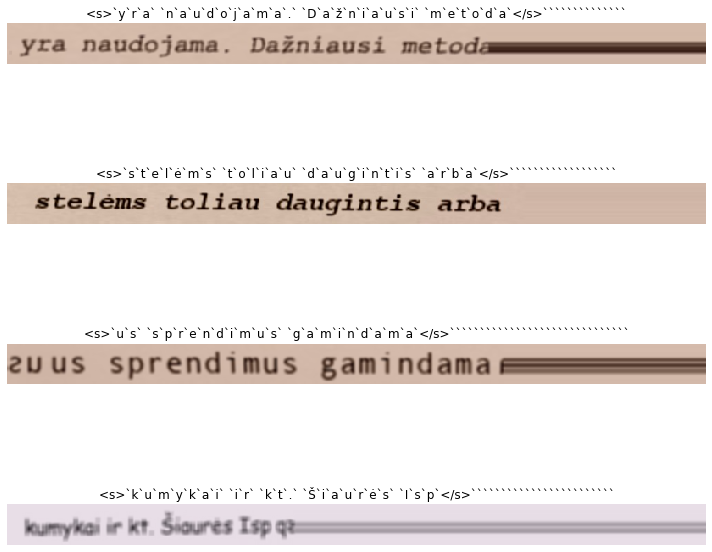

In [ ]:
data.show_batch(4, figsize=(10,10))

In [ ]:
dl = iter(data.valid_dl)
i, o = next(dl)
i.shape

torch.Size([16, 3, 48, 912])

In [ ]:
data.c

116

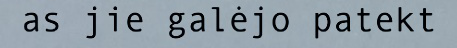

In [ ]:
data.x[0]

In [ ]:
data.y[0]

MultiCategory <s>`a`s` `j`i`e` `g`a`l`ė`j`o` `p`a`t`e`k`t`</s>

In [ ]:
data.y[0].data

tensor([  1,  68,  86,   3,  77,  76,  72,   3,  74,  68,  79, 103,  77,  82,
          3,  83,  68,  87,  72,  78,  87,   2])

### Model

In [ ]:
#export
def conv_output(w, ss, ps=None, ks=3):
    ''' image width, strides, pools, kernel sizes '''
    for s,p,k in zip(ss,ps,ks):
        s = s[1] if isinstance(s, tuple) else s
        w = w if w%s == 0 else w + 1
        w = (w - k + 2*p)/s + 1 if p is not None else w/s
    return int(w)

conv_output(129, [2, 1, 2, 1, (2,1), (2,1), 1], [None] * 6 + [0], [3, 3, 3, 3, 3, 3, 3])

31

In [ ]:
def compose(funcs):
    def func_out(x, *args):
        for f in listify(funcs):
            x = f(x, *args)
        return x
    return func_out

In [ ]:
#export
_apply_layer = lambda args: args[1](args[0]) # args[0]: x, args[1]: layer => layer(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True, shared_qk=False):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt, self.v_wgt = [nn.Linear(d_model, n_heads*d_head, bias=bias) for o in range(2)]
        self.k_wgt = self.q_wgt if shared_qk else nn.Linear(d_model, n_heads*d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask=None):
        ''' [b,s_d,512], [b,s_e,512], [1,1,s_d,s_e] -> [b,s_d,512] '''
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(_apply_layer, zip([q,kv,kv], [self.q_wgt,self.k_wgt,self.v_wgt])) # [b,s_d,h*512], [b,s_e,h*512] x 2
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv)) # [b,s_d,h,512], [b,s_e,h,512] x 2
        wq,wv = map(lambda x:x.permute(0, 2, 1, 3), (wq,wv)) # [b,h,s_d,512], [b,h,s_e,512]
        wk = wk.permute(0, 2, 3, 1) # [b,h,512,s_e]
        attn_score = torch.matmul(wq, wk) # [b,h,s_d,s_e]
        if self.scale: attn_score.div_(self.d_head ** 0.5)
        if mask is not None: # NOTE: masks only ones, not zeros!
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score) # [b,h,s_d,s_e]
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1)) # [b,h,s_d,s_e]
        attn_vec = torch.matmul(attn_prob, wv) # [b,h,s_d,512]
        attn_vec = attn_vec.permute(0, 2, 1, 3).contiguous().contiguous() # [b,s_d,h,512]
        attention = attn_vec.view(bs, seq_len, -1) # [b,s_d,h*512]
        return self.ln(q + self.drop_res(self.out(attention)))

In [ ]:
mha = MultiHeadAttention(n_heads=8, d_model=512)
mha(torch.zeros(4,24,512), torch.zeros(4,16,512), torch.zeros(1,1,24,16, dtype=bool)).shape

torch.Size([4, 24, 512])

In [ ]:
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., activ_func=partial(nn.ReLU, inplace=True), double_drop:bool=True):
    ''' [...,d] -> [...,d] '''
    layers = [nn.Linear(d_model, d_ff), activ_func()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

In [ ]:
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    def __init__(self, n_heads, d_model, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None):
        ''' [b,s_e,512], [1,1,s_e,s_e] -> [b,s_e,512] '''
        return self.ff(self.mha(x, x, mask=mask))

In [ ]:
e = EncoderBlock(n_heads=8, d_model=512, d_inner=1024)
e(torch.zeros(4,16,512), torch.zeros(1,1,16,16, dtype=bool)).shape

torch.Size([4, 16, 512])

In [ ]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    def __init__(self, n_heads, d_model, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None):
        ''' [b,s_d,512], [b,s_e,512], [1,1,s_d,s_d] -> [b,s_d,512] '''
        return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

In [ ]:
d = DecoderBlock(n_heads=8, d_model=512, d_inner=1024)
d(torch.zeros(4,24,512), torch.zeros(4,16,512), torch.zeros(1,1,24,24, dtype=bool)).shape

torch.Size([4, 24, 512])

In [ ]:
def get_output_mask(inp, pad_idx=1):
    ''' [b,s_e,...] -> [1,1,s_e,s_e] '''
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].type(torch.bool)

In [ ]:
get_output_mask(torch.ones(4,4)).type(torch.int).squeeze()

tensor([[0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0]], dtype=torch.int32)

In [ ]:
class PositionalEncoding(Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int): self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))

    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [ ]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, emb_sz, vocab_sz=None, drop=0.):
        super().__init__()
        self.emb_sz = emb_sz
        if vocab_sz is None: self.embed = None
        else: self.embed = nn.Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(drop)
        self.alpha = nn.Parameter(tensor(1.))
    
    def forward(self, inp):
        ''' [] -> [] '''
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        if self.embed is not None: inp = self.embed(inp)
        return self.drop(inp + self.alpha * self.pos_enc(pos))
#         return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

In [ ]:
def compose(funcs):
    def func_out(x, *args):
        for f in listify(funcs):
            x = f(x, *args)
        return x
    return func_out

In [ ]:
class Transformer(Module):
    def __init__(self, out_vsz, n_layers=6, n_heads=8, d_model=512, d_inner=1024, p=0.1, 
                 bias=True, scale=True, double_drop=True, pad_idx=1, one_hot_encoded=False):
        self.enc_emb = TransformerEmbedding(d_model, drop=0.) # no need to embed encoding from cnn output
        self.dec_emb = TransformerEmbedding(d_model, vocab_sz=out_vsz, drop=0.)
#         self.dec_emb = PositionalEncoding(d_model)
        args = (n_heads, d_model, d_inner, p, bias, scale, double_drop)
        self.encoders = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoders = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        # self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        self.one_hot_encoded = one_hot_encoded
        
    def forward(self, inp, out):
        ''' [b,s_e,512], [b,s_d,c] or [b,s_d] -> [b,s_d,c] (c - num classes) '''
        if self.one_hot_encoded: out = out.argmax(-1) # [b,s_d]
        mask_out = get_output_mask(out, self.pad_idx) # [1,1,s_d,s_d]
#         out = self.dec_emb(torch.zeros_like(out)) 
        out = self.dec_emb(out) 
        enc = self.enc_emb(inp) # 
        enc = compose(self.encoders)(enc) # [b,s_e,512]
        out = compose(self.decoders)(out, enc, mask_out) # [b,s_d,512]
        return self.out(out)

In [ ]:
Transformer(out_vsz=20, one_hot_encoded=True)( torch.zeros(4,12,512), torch.zeros(4,16,20) ).shape

torch.Size([4, 16, 20])

In [ ]:
def _create_cnn(kernels, strides, channels, padding):
    layers = []
    for i,o,k,s,p in zip([3] + channels[:-1], channels, kernels, strides, padding):
        layers.append( conv_layer(ni=i, nf=o, ks=k, stride=s, padding=p) )
    return nn.Sequential(*layers)

In [ ]:
#export
class MultiCnnLayer(nn.Module):
    def __init__(self, ni, nf, ks, stride, padding):
        super().__init__()
        self.conv = conv_layer(ni=ni, nf=nf, ks=ks, stride=stride, padding=padding)
        self.pool = nn.MaxPool2d(stride)
        self.conv2 = conv_layer(ni=ni, nf=nf, ks=1, stride=1, padding=padding)
        
    def forward(self, x):
        return self.conv2(self.pool(x)) + self.conv(x)
#         return self.bn(self.relu(x + self.conv(x)))

class CNN(nn.Module):
    def __init__(self, d_model, cnn_layers, kernels, strides, channels, padding):
        super().__init__()
        layers = []
        for layer,i,o,k,s,p in zip(cnn_layers, [3] + channels[:-1], channels, kernels, strides, padding):
            layers.append( layer(ni=i, nf=o, ks=k, stride=s, padding=p) )
        self.cnn = nn.Sequential(*layers)
        b,c,h,w = self.cnn(torch.zeros(1,3,48,128)).shape
        print('CNN output = h:{} c:{}'.format(h,c))
#         self.out = nn.Linear(channels[-1]*h, d_model)
        
    def forward(self, x):
        x = self.cnn(x).permute(0,3,1,2)
        b,w,c,h = x.shape
        return x.view(b,w,-1) # [b,c,h,w]
#         return self.out(x.view(b,w,-1)) # [b,c,h,w]

In [ ]:
#export
class TransformerModel(nn.Module):

    def __init__(self, nclass=10, nc=3, n_layers=6, d_model=512, d_ff=1024, use_rnn=False, rnn_hidden=256, bidirectional=False):
        super().__init__()
        self.nclass = nclass
        strides = [2, 1, (2,1), 1, (2,1), (2,1), 1]
        channels = [64, 128, 256, 256, 512, 512, 512]
        cnn_layers = [conv_layer] * len(strides)
        kernels = [3] * len(strides)
        padding = [None] * (len(strides)-1) + [0] # None - out size doesnt change
        self.kernels, self.strides, self.channels, self.padding = kernels, strides, channels, padding
        
        self.cnn = CNN(d_model, cnn_layers, kernels, strides, channels, padding)
        
        self.transformer = Transformer(nclass, n_layers=n_layers, n_heads=8, d_model=d_model, d_inner=d_ff)

    def forward(self, x, y_input):
        ''' [b,c,h,w], [b,s_d] '''
        x = self.cnn(x) # [b,s_e,512]
        return self.transformer(x, y_input) # [b,s_d,c]

In [ ]:
TransformerModel()(torch.zeros(2,3,48,128), torch.zeros(2,3).long()).shape

CNN output = h:1 c:512


torch.Size([2, 3, 10])

### Learner

In [ ]:
def loss_func(y_pred, y_true):
    # y_pred: [b,s_d,c], y_true: [b,s_d]
    mask = y_true != pad_idx
    return CrossEntropyFlat()(y_pred[mask], y_true[mask])

In [ ]:
#export
def wer(s1,s2):
    ''' s1 - true text, s2 - pred text '''
    d = np.zeros([len(s1)+1,len(s2)+1])
    d[:,0] = np.arange(len(s1)+1)
    d[0,:] = np.arange(len(s2)+1)

    for j in range(1,len(s2)+1):
        for i in range(1,len(s1)+1):
            if s1[i-1] == s2[j-1]:
                d[i,j] = d[i-1,j-1]
            else:
                d[i,j] = min(d[i-1,j]+1, d[i,j-1]+1, d[i-1,j-1]+1)

    return d[-1,-1]/len(s1)

word_error = wer( 'black frog jumped away'.split(' '), 'black frog jumped awayyy'.split(' ') )
char_error = wer( 'black frog jumped away', 'black frog jumped awayyy' )
char_error, word_error

(0.09090909090909091, 0.25)

In [ ]:
def decode_idxes(char_idxes):
    ''' [n] -> str '''
    chars = []
    for i in char_idxes:
        chars.append(learner.data.classes[i])
        if i == eos_idx: break
    return ''.join(chars)

In [ ]:
#export
def CER(y_pred, y_true):
    # y_pred: [b,s_d,c], y_true: [b,s_d]
    y_pred = y_pred.argmax(-1)
    m = 0
    for yp, yt in zip(y_pred, y_true):
        if yp.shape == torch.Size([]): continue
        yt_text = decode_idxes(yt)
        yp_text = decode_idxes(yp)
        m += wer(yt_text, yp_text)
    return tensor(m / len(y_pred))

In [ ]:
#export
def WER(y_pred, y_true):
    # y_pred: [b,s_d,c], y_true: [b,s_d]
    y_pred = y_pred.argmax(-1)
    m = 0
    for yp, yt in zip(y_pred, y_true):
        if yp.shape == torch.Size([]): continue
        yt_text = decode_idxes(yt)
        yp_text = decode_idxes(yp)
        m += wer(yt_text.split(' '), yp_text.split(' '))
    return tensor(m / len(y_pred))

In [ ]:
data = create_data(main_df, bs=6)
pad_idx = data.classes.index(label_delim)

def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=pad_idx) # add 1 to last dim
    return [x,y[:,:-1]], y[:,1:]

data.add_tfm(shift_tfm)

In [ ]:
# either load or create new learner
learner = load_inference('transformer_ocr')
learner.data = data

In [ ]:
model = TransformerModel(nclass=data.c)
learner = Learner(data, model, loss_func=loss_func, metrics=[CER, WER])
learner.callbacks.append(ShowGraph(learner))

# learner.show_results(DatasetType.Train, rows=1)

CNN output = h:1 c:512


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 1.58E-03


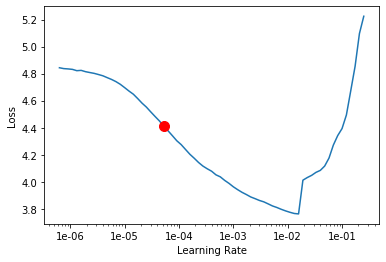

In [ ]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,CER,WER,time
0,1.896583,1.864931,0.478977,1.302544,19:34


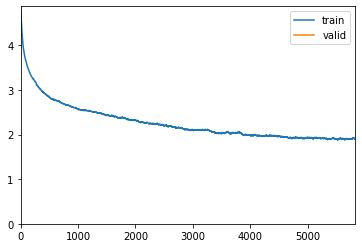

In [ ]:
learner.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,CER,WER,time
0,1.828417,1.800893,0.458167,1.226217,19:39
1,0.717259,0.648207,0.211224,0.735063,19:47
2,0.153209,0.150015,0.040341,0.219142,19:41
3,0.110234,0.082611,0.021008,0.125084,19:45
4,0.063221,0.049634,0.012308,0.076759,19:45
5,0.039645,0.036435,0.008675,0.057132,19:43
6,0.026903,0.028789,0.007227,0.045367,19:43
7,0.014313,0.021449,0.005164,0.034099,19:47
8,0.006743,0.017733,0.004081,0.026473,19:43
9,0.006472,0.017417,0.003962,0.025890,19:41


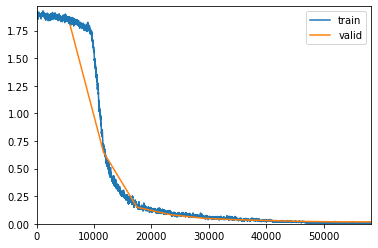

In [ ]:
learner.fit_one_cycle(10, 1e-4)

In [ ]:
save_inference(learner, 'transformer_fontsynth_ocr')

### Examples

In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid, num_items=100):
    learn.model.eval().cpu()
    inputs, targets, outputs = [],[],[]
    j = 0
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            j += 1
            if j > num_items: break
            xb[0], xb[1] = xb[0].cpu(), xb[1].cpu()
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [ ]:
i,t,o = get_predictions(learner, ds_type=DatasetType.Valid, num_items=10)

<s>`s` `t`ą`k`a`r`t` `į`k`ū`r`ė` `n`e`d`ž`i`o`k`l`ė`s` `p`i`l`į`.` `A`p`i`e` `p`</s>
``<s>`s` `t`ą`k`a`r`t` `į`k`ū`r`ė` `m`e`d`ž`i`o`k`l`ė`s` `p`i`l`į`.` `A`p`i`e` `p


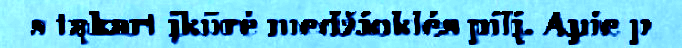

In [ ]:
j = 6
print(o[j])
print(t[j])
i[j]

In [ ]:
learner.model.transformer.enc_emb.alpha, learner.model.transformer.dec_emb.alpha

(Parameter containing:
 tensor(1.0527, requires_grad=True), Parameter containing:
 tensor(1.0418, requires_grad=True))